In [1]:
import os
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [2]:
PROJECT_DIR = Path(os.environ['PROJECT_DIR'])
PREPROCESSED_DATA_PATH = PROJECT_DIR / 'data/preprocessed_data'
PROCESSED_DATA_PATH = PROJECT_DIR / 'data/processed_data'

In [3]:
df = pd.read_csv(PREPROCESSED_DATA_PATH / 'data.csv')
split_df = pd.read_csv(PREPROCESSED_DATA_PATH / 'split.csv').set_index('participant_id')
df['split'] = df['participant_id'].apply(lambda i: split_df.loc[i]['split'])

In [4]:
train_df = df[df['split'] == 'train']
test_df = df[df['split'] == 'test']

In [5]:
y_train = train_df['phq_binary'].to_numpy().astype(int)
y_test = test_df['phq_binary'].to_numpy().astype(int)

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, mannwhitneyu

def is_significant(p_value, alpha: float = 0.05):
    if p_value < alpha:
        return True
    return False

def standardize_columns(df):
    standardized_df = df.copy()

    # Standardize the features
    means = df.mean()
    stds = df.std()
    standardized_df = (df - means) / stds
    
    return standardized_df, means, stds

In [7]:
def select_features(df, alpha: float = 0.001, grouping_variable: str = 'phq_binary', group_1_label=0, group_2_label=1):
    selected_features = {}
    for i, feature in enumerate(df.columns):  
        if feature == grouping_variable:
            continue
        
        # assess the distributions in groups
        _, shapiro_p1 = shapiro(df[df[grouping_variable] == group_1_label][feature])
        _, shapiro_p2 = shapiro(df[df[grouping_variable] == group_2_label][feature])
    
        # assess the differences between groups
        if shapiro_p1 > 0.05 and shapiro_p2 > 0.05:
            # t-test for independent samples
            _, p_val = ttest_ind(
                df[df[grouping_variable] == group_1_label][feature], 
                df[df[grouping_variable] == group_2_label][feature], 
                nan_policy='omit'
            )
        else:
            # Mann-Whitney U test
            _, p_val = mannwhitneyu(
                df[df[grouping_variable] == group_1_label][feature], 
                df[df[grouping_variable] == group_2_label][feature], 
                nan_policy='omit'
            )
    
        if is_significant(p_val, alpha):
            selected_features[feature] = p_val
            
    return selected_features

In [8]:
def remove_correlated(df, threshold=0.9):
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Create a boolean mask for the upper triangle of the correlation matrix
    upper_triangle_mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Find index of feature columns with correlation greater than threshold
    to_drop = [column for column in range(corr_matrix.shape[1] - 1) if any(corr_matrix.iloc[column, :-1][upper_triangle_mask[column, :-1]] > threshold)]
    
    # Drop marked features
    df_reduced = df.drop(df.columns[to_drop], axis=1)
    
    return df_reduced

In [9]:
def correlation_matrix(df, df_features, title: str = '', correlation_threshold: float = 0.8, annot=False):
    # correlation matrix on selected features with high correlated features removal
    corr_m = pd.concat(
        [
            # remove_correlated(pd.concat([df_features, df['phq_binary'].reset_index(drop=True)], axis=1), threshold=correlation_threshold),
            remove_correlated(df_features, threshold=correlation_threshold),
            df['phq_binary'].reset_index(drop=True)
        ], 
        axis=1
    ).corr()
    
    # correlation martix mask
    up_triang = np.triu(np.ones_like(corr_m)).astype(bool)
    up_triang[:, -1] = 0
    
    # display
    if corr_m.shape[0] > 20:
        plt.figure(figsize=(corr_m.shape[0] * 10 // 30, corr_m.shape[0] * 8 // 30))
    else:
        plt.figure(figsize=(8, 6))
        
    sns.heatmap(corr_m.iloc[:-1, :], mask=up_triang[:-1, :], annot=annot, fmt='.2f', linewidth=.5)
    plt.tight_layout()
    plt.title(title)

    return corr_m['phq_binary'].iloc[:-1].to_dict()

In [10]:
features_paths = list(PROCESSED_DATA_PATH.rglob('*.csv'))
features_paths = {
    path.stem.split('_')[0]: {
        p.stem.split('_')[-1]: p for p in features_paths if p.stem.startswith(path.stem.split('_')[0])
    } 
    for path in features_paths
}
features_paths

{'Glottal': {'train': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Glottal_train.csv')},
 'Phonation': {'test': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Phonation_test.csv'),
  'train': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Phonation_train.csv')},
 'Prosody': {'test': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Prosody_test.csv'),
  'train': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Prosody_train.csv')},
 'Other': {'test': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Other_test.csv'),
  'train': PosixPath('/workspace/speech-based-distress-recognition/data/processed_data/disvoice_features/Other_train.csv')},
 'RepLearning': {'train': PosixPath('/workspace/speech-based-distress-recogn

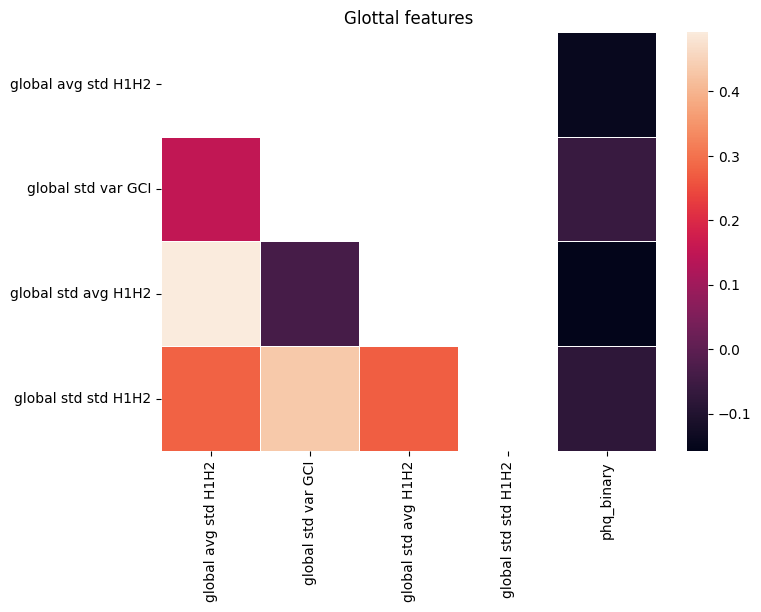

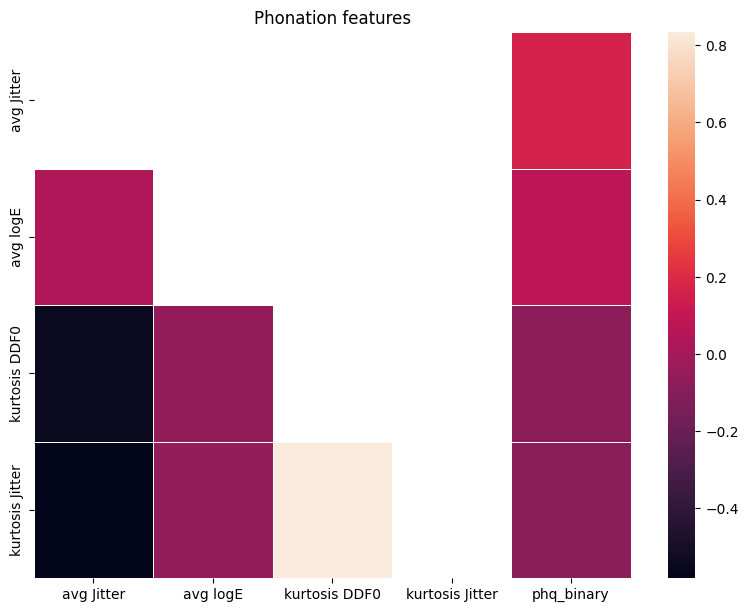

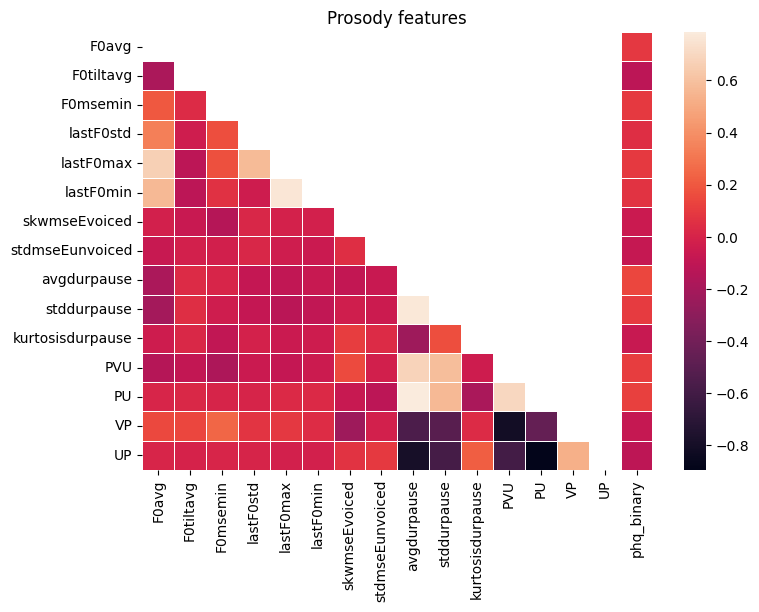

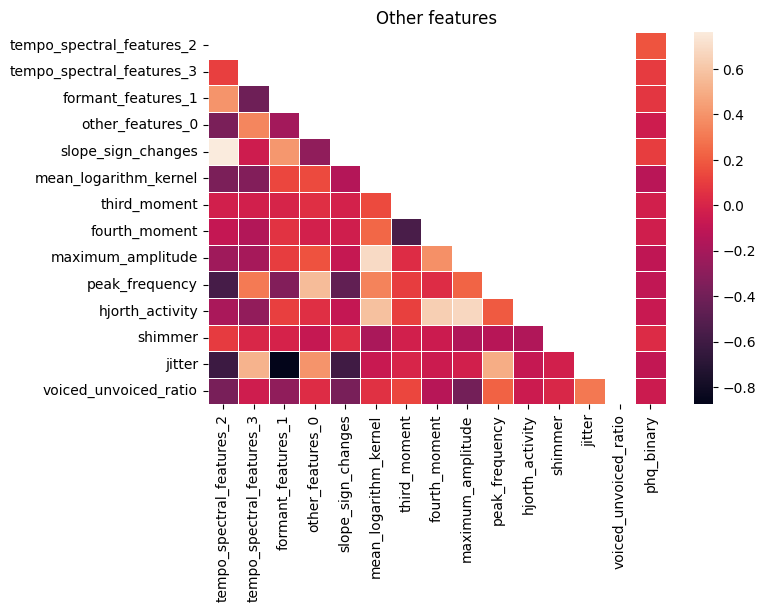

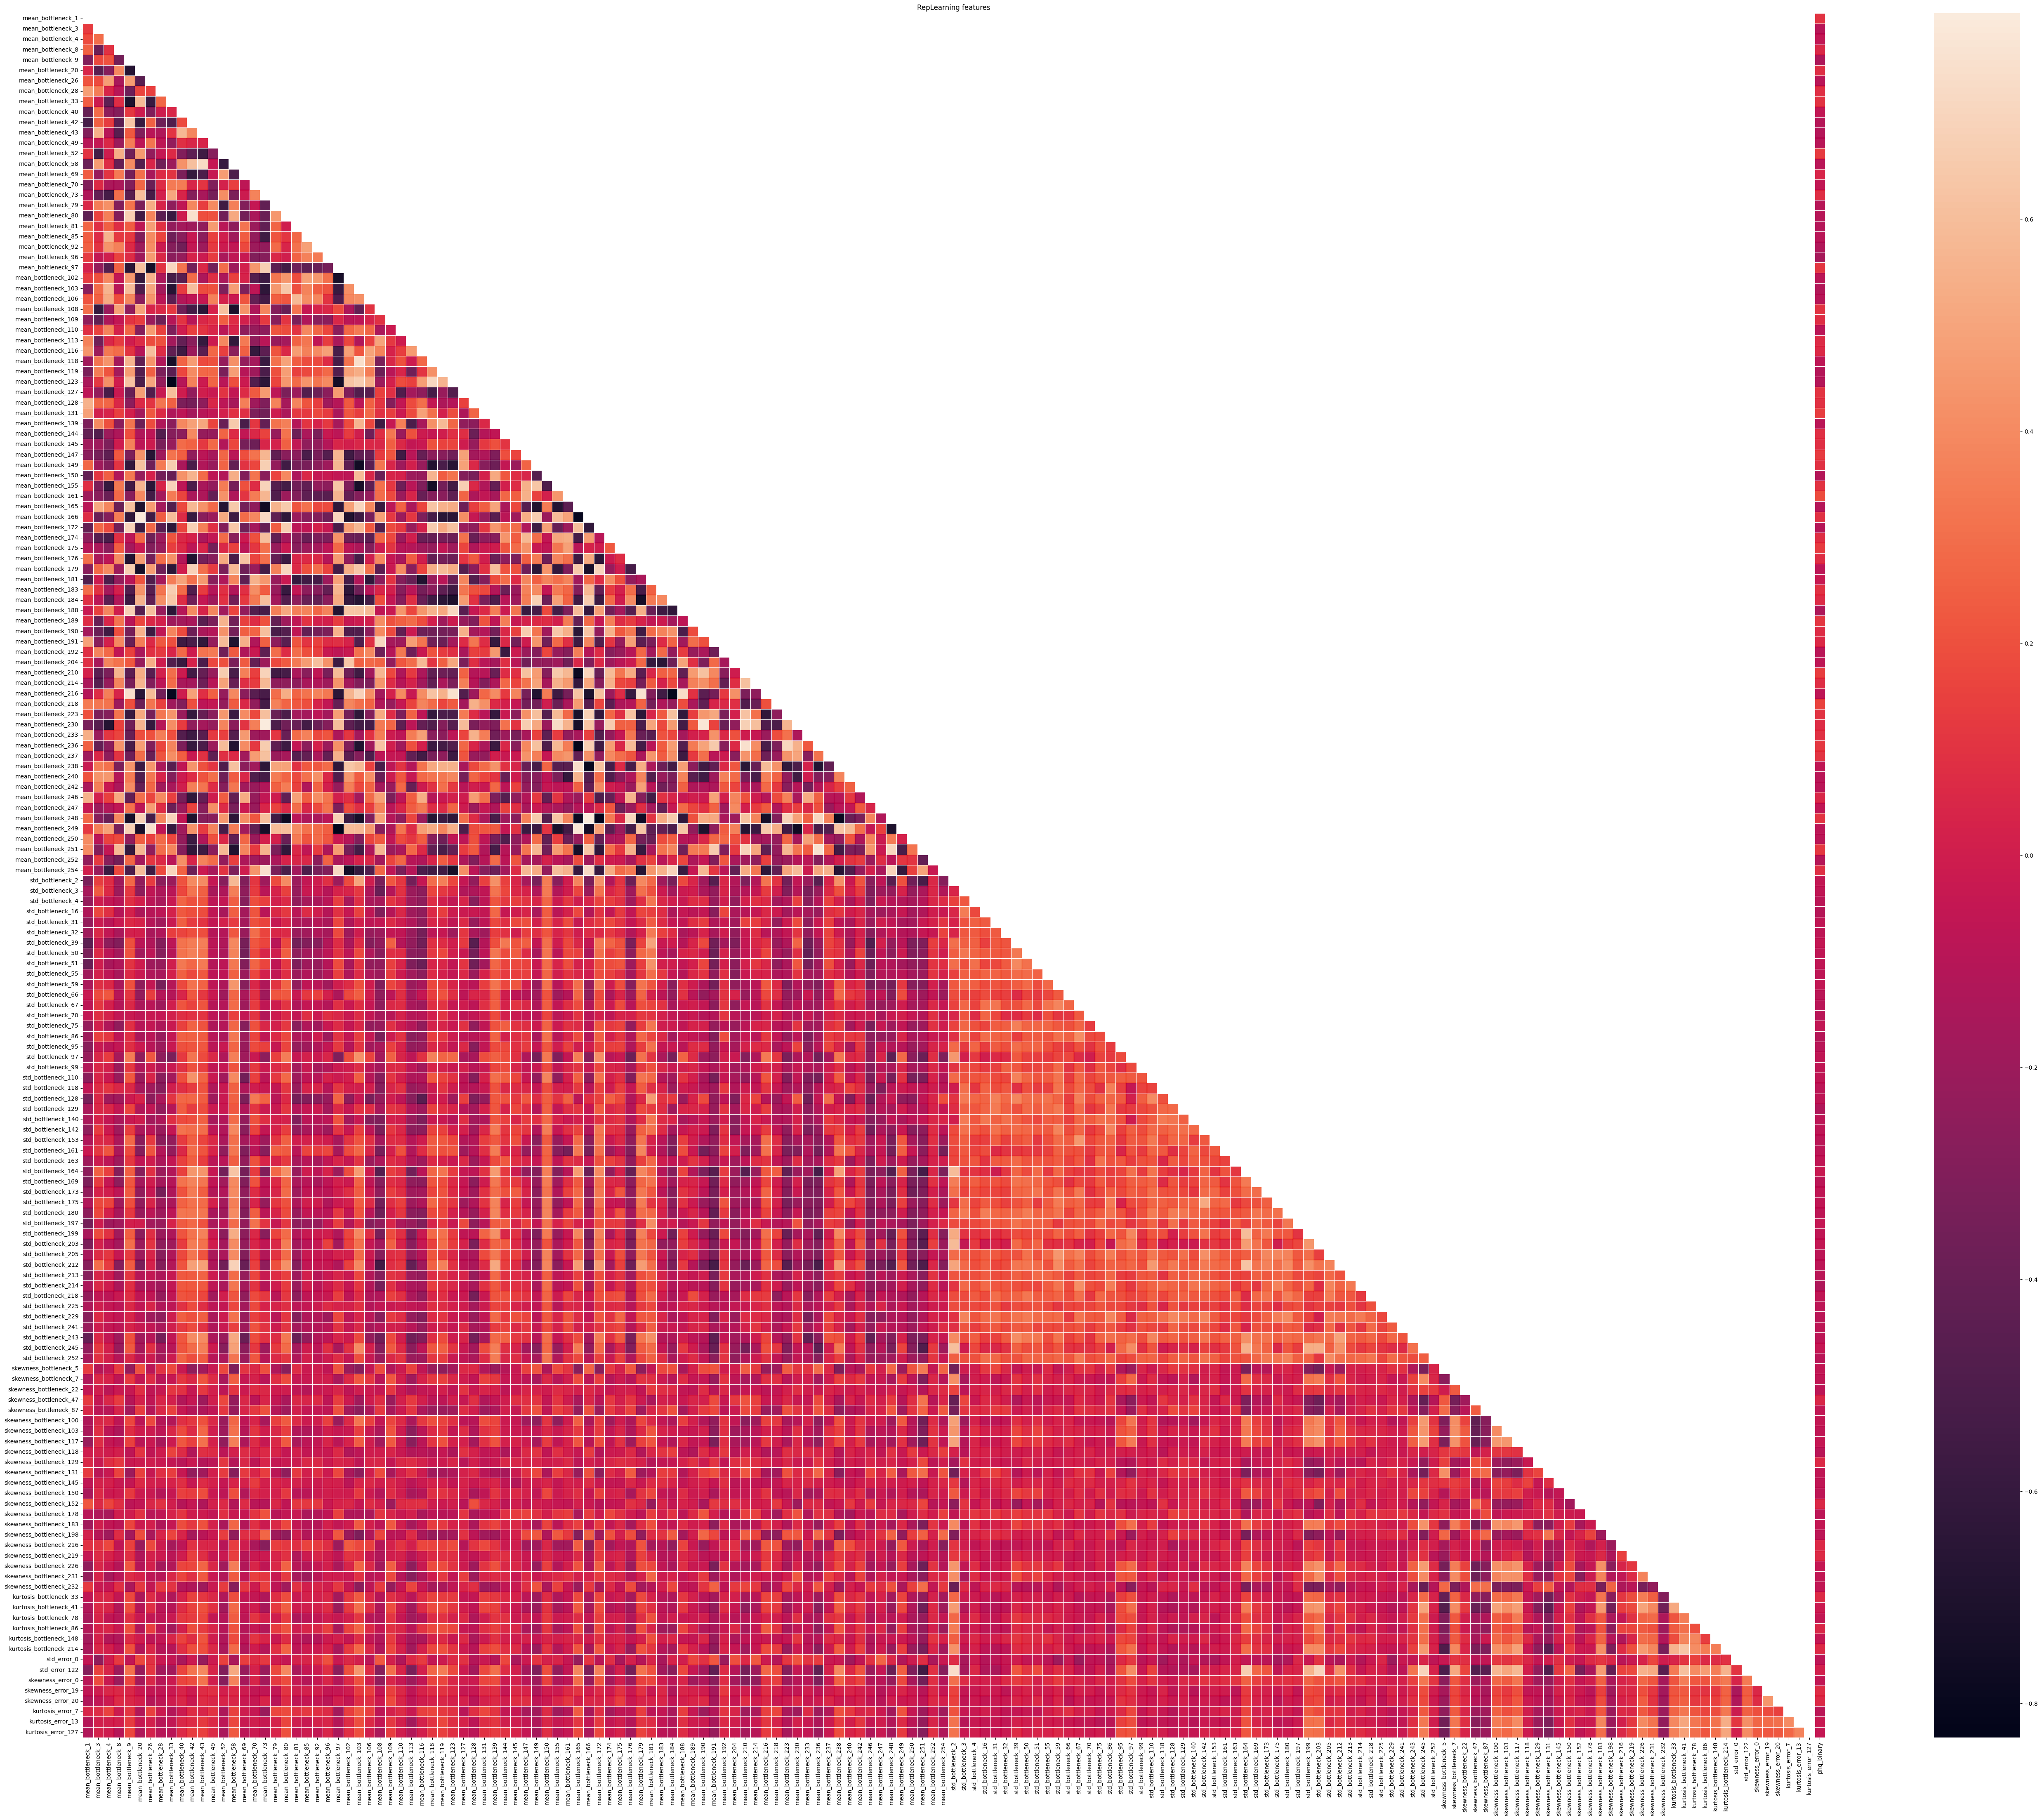

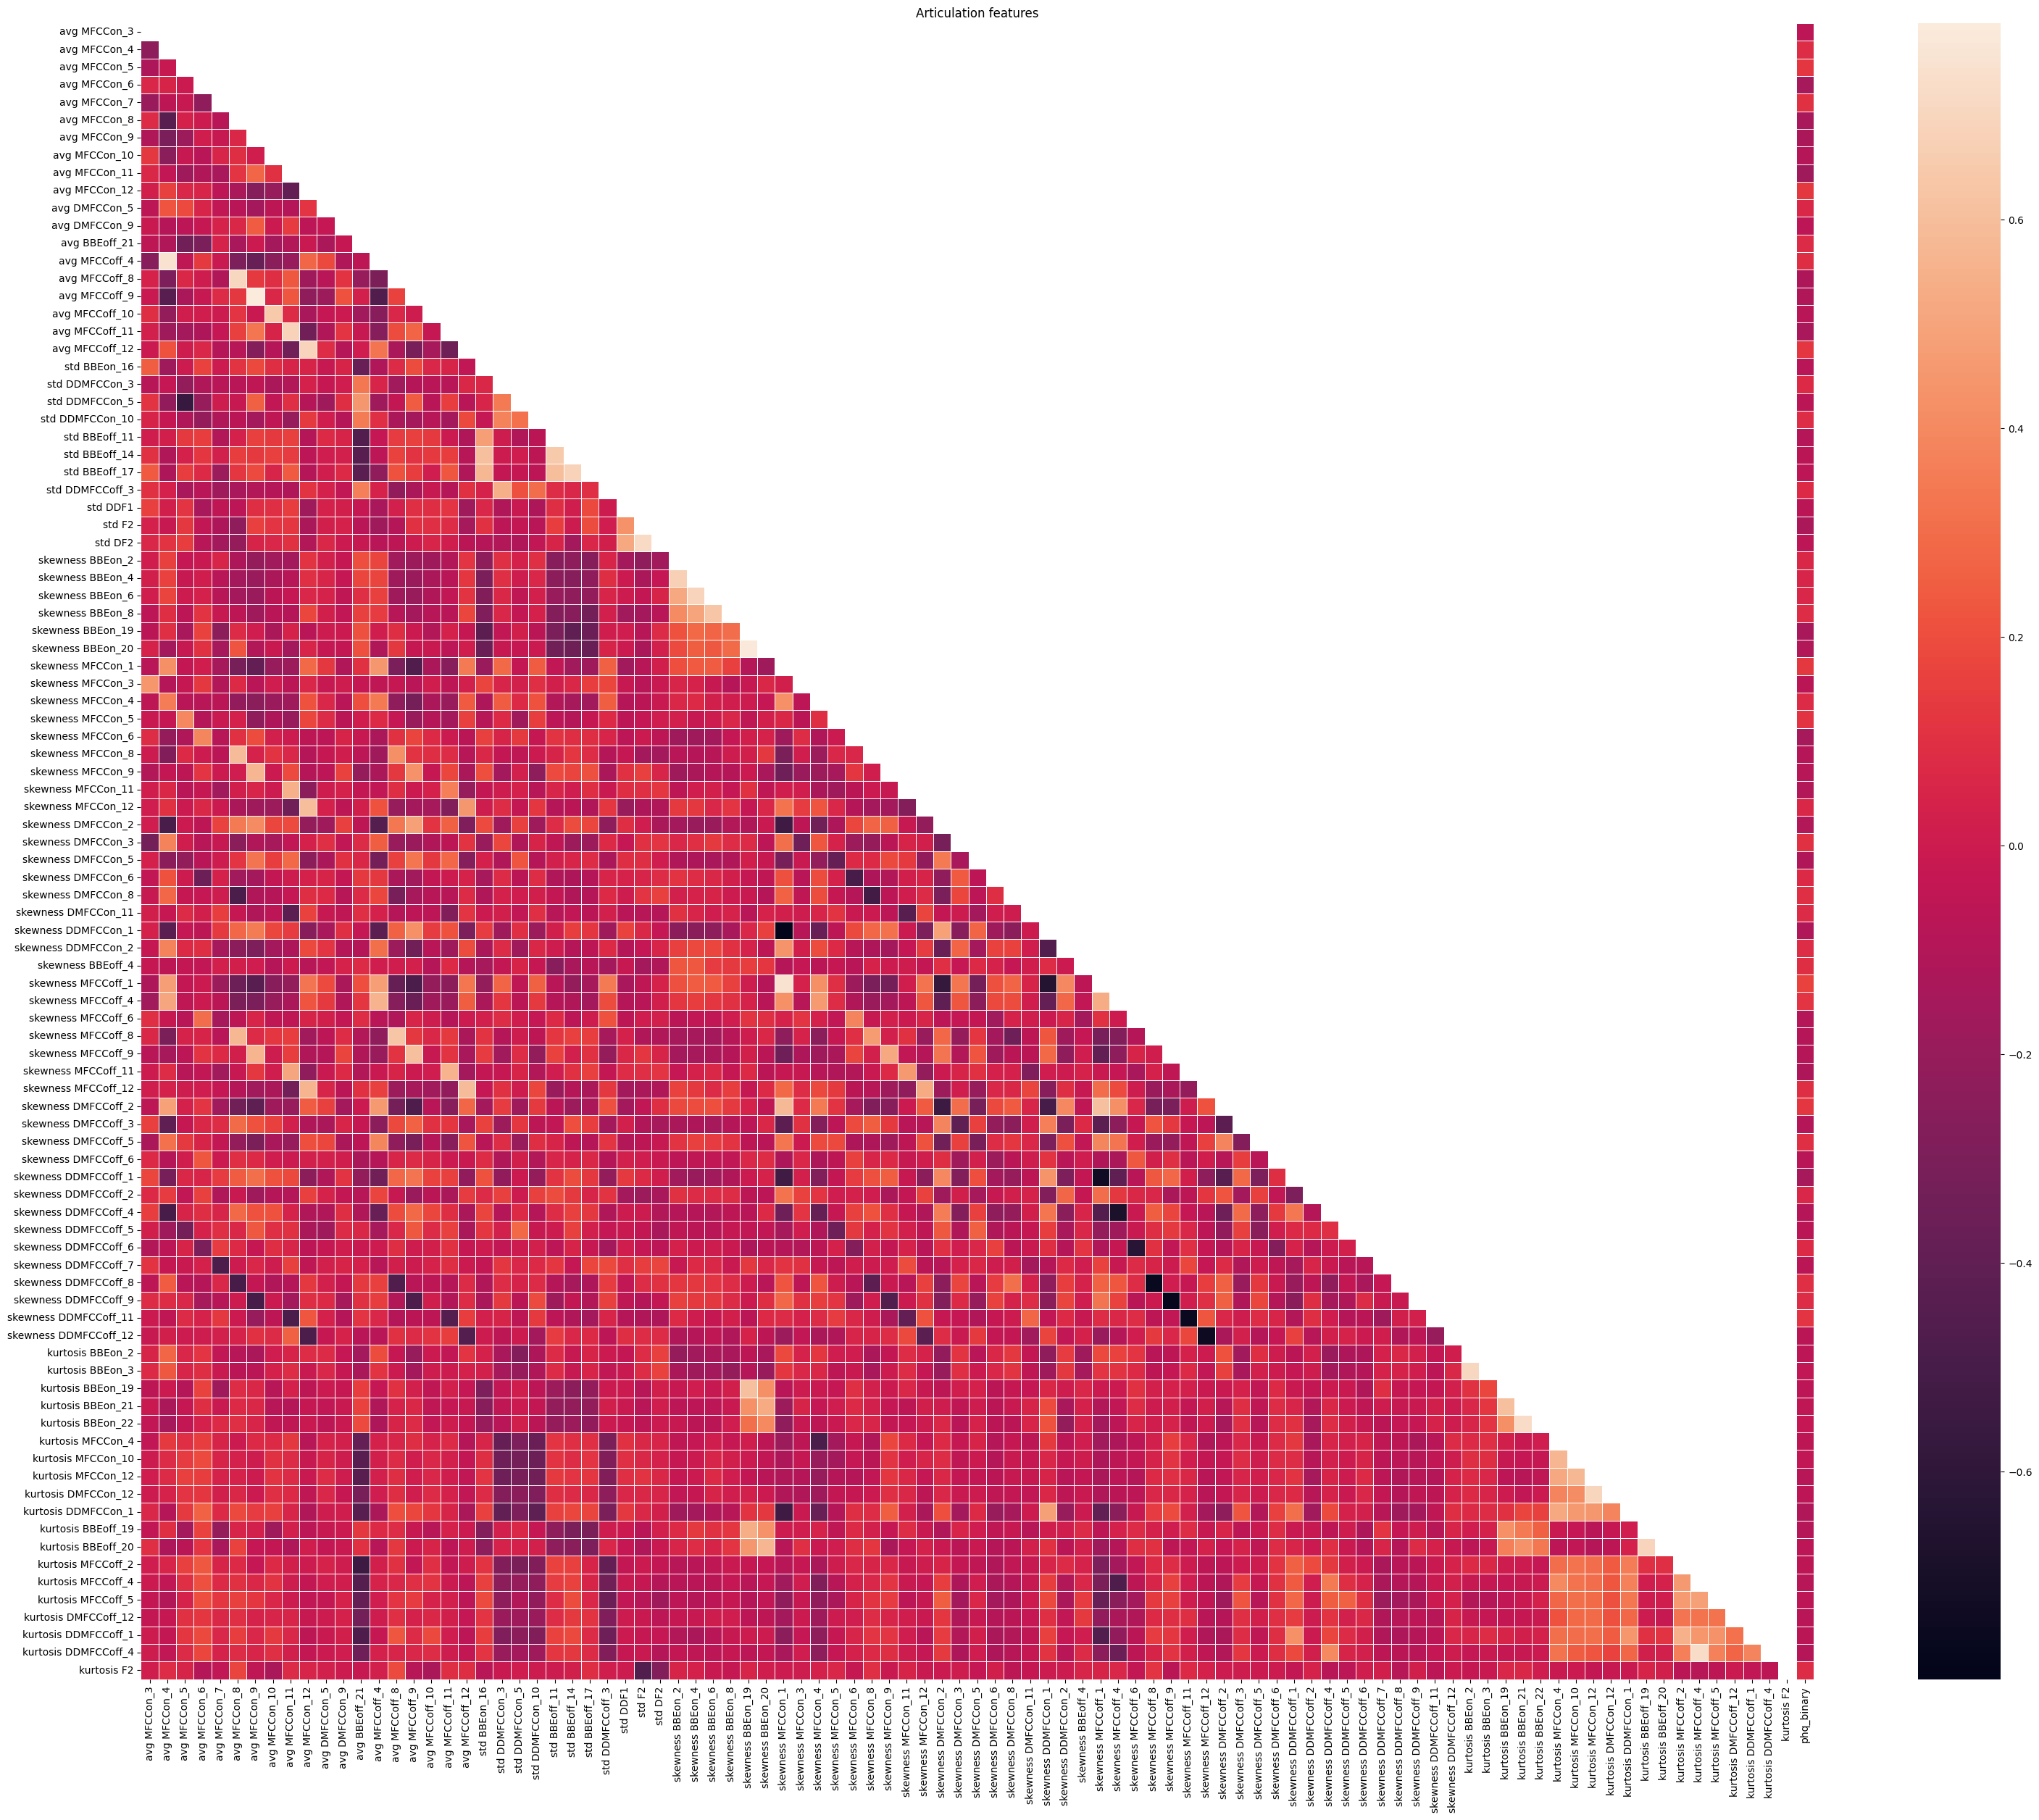

In [11]:
all_significant_features = []
all_selected_features = {}

for features_name in features_paths.keys():
    # read data
    path = features_paths[features_name]['train']
    features = pd.read_csv(path).reset_index(drop=True)

    # standardize
    features, features_means, features_stds = standardize_columns(features)
    # features['phq_binary'] = train_df['phq_binary'].reset_index(drop=True)
    features['phq_binary'] = train_df.groupby('participant_id').apply(
        lambda group: group['phq_binary'], 
        include_groups=False
    ).reset_index(drop=True)

    # select statistically significant
    selected_features = select_features(features, alpha=0.001)
    selected_features = list(selected_features.keys())
    all_significant_features += selected_features

    # remove features with very strong correlation and plot correlation matrix
    target_correlations = correlation_matrix(train_df, features[selected_features], title=f'{features_name} features')
    all_selected_features |= target_correlations
    plt.show()

In [12]:
pd.Series(all_selected_features).sort_values(ascending=False)

mean_bottleneck_161          0.189010
tempo_spectral_features_2    0.177542
skewness MFCCoff_1           0.164177
avg Jitter                   0.159983
mean_bottleneck_218          0.155304
                               ...   
skewness DDMFCCoff_1        -0.144982
avg MFCCon_6                -0.145805
global std avg H1H2         -0.157936
mean_bottleneck_96          -0.162695
avg MFCCon_11               -0.176727
Length: 297, dtype: float64

In [13]:
training_features = pd.Series(all_selected_features)
training_features = training_features[training_features > 0.1]  # correlation at least 0.1
training_features = list(training_features.index)

In [14]:
training_features

['avg Jitter',
 'avgdurpause',
 'stddurpause',
 'PVU',
 'PU',
 'tempo_spectral_features_2',
 'slope_sign_changes',
 'mean_bottleneck_52',
 'mean_bottleneck_97',
 'mean_bottleneck_108',
 'mean_bottleneck_127',
 'mean_bottleneck_131',
 'mean_bottleneck_147',
 'mean_bottleneck_155',
 'mean_bottleneck_161',
 'mean_bottleneck_175',
 'mean_bottleneck_189',
 'mean_bottleneck_210',
 'mean_bottleneck_218',
 'mean_bottleneck_236',
 'mean_bottleneck_237',
 'mean_bottleneck_248',
 'mean_bottleneck_251',
 'avg MFCCon_5',
 'avg MFCCon_7',
 'avg MFCCon_12',
 'avg MFCCoff_12',
 'skewness MFCCon_1',
 'skewness MFCCon_5',
 'skewness DMFCCon_3',
 'skewness MFCCoff_1',
 'skewness MFCCoff_4',
 'skewness DMFCCoff_2',
 'skewness DDMFCCoff_11']

In [15]:
train_features_df = pd.DataFrame()

for features_name in features_paths.keys():
    # read data
    path = features_paths[features_name]['train']
    features = pd.read_csv(path).reset_index(drop=True)
    train_features_df = pd.concat([train_features_df, features], axis=1)

train_features_df = train_features_df.fillna(train_features_df.median())

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

from src.evaluation.sklearn_evaluator import SklearnEvaluator

In [17]:
def preprocessing_fn(data, train_index, test_index):
    data_train = data.iloc[train_index].copy()
    data_train, data_train_means, data_train_stds = standardize_columns(data_train)

    data_test = data.iloc[test_index].copy()
    data_test = (data_test - data_train_means) / data_train_stds
    return data_train, data_test

In [18]:
precision_recall_f2score_support = lambda *args, **kwargs: precision_recall_fscore_support(*args, beta=2., **kwargs)

In [21]:
model = LogisticRegression()

evaluator = SklearnEvaluator(
    model=model,
    preprocessing_fn=preprocessing_fn,
    inference_fn=model.predict,
    X=train_features_df,
    Y=train_df[['phq_binary']].reset_index(drop=True),
    data_groups=train_df['participant_id'].reset_index(drop=True),
    score_fns=[precision_recall_f2score_support]
)

results = evaluator.cross_validation(n_folds=5, iterations=5)

Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
for class_label in [0, 1]:
    mean_values = np.array(results['<lambda>'])[:, :, :, class_label].squeeze().mean(0)
    std_values = np.array(results['<lambda>'])[:, :, :, class_label].squeeze().std(0)

    metrics_df = pd.DataFrame({
        'Metric': ['Precision', 'Recall', 'F2', 'Support'],
        'Mean': mean_values,
        'Std': std_values
    })
    metrics_df.set_index('Metric', inplace=True)
    print(metrics_df)
    print(f'Label: "{class_label}"', end='\n\n')

                 Mean       Std
Metric                         
Precision    0.876071  0.014629
Recall       0.891929  0.017732
F2           0.888613  0.014334
Support    383.400000  7.589466
Label: "0"

                 Mean       Std
Metric                         
Precision    0.618221  0.045144
Recall       0.580062  0.044518
F2           0.586554  0.039170
Support    115.200000  7.509993
Label: "1"

